# 1. Libraries & Sample Data
The first step is to load our Python Libraries and download the sample data. The dataset represents Apple stock price (1d bars) for the year 2010

In [1]:
# Load Python Libraries
import math
import keras
import random
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


from tqdm.notebook import tqdm
from collections import deque
from IPython.display import display, HTML
from sklearn.preprocessing import StandardScaler

# for dataframe display
pd.set_option('display.max_rows', None)
def display_df(df):
    # Puts the scrollbar next to the DataFrame
    display(HTML("<div style='height: 200px; overflow: auto; width: fit-content'>" + df.to_html() + "</div>"))

# for reproducability of training rounds
keras.utils.set_random_seed(42)

In [2]:
# Download Sample Data
data = pd.read_csv('GOOG_2009-2010_6m_RAW_1d.csv')

# 2. Exploratory Data Analysis
Next, we want to analyze our data. Display the data as a dataframe, and plot some relevant data so you can get an idea of what our dataset looks like.

In [3]:
# Display as Dataframe
display_df(data)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2009-04-01,8.562406,8.847836,8.483452,8.819193,8.819193,132542948.0
1,2009-04-02,9.048833,9.209481,8.974362,9.028658,9.028658,180192885.0
2,2009-04-03,9.078472,9.258298,8.916578,9.209979,9.209979,152160204.0
3,2009-04-06,9.140738,9.210975,9.001261,9.171623,9.171623,131703815.0
4,2009-04-07,NaN,NaN,NaN,NaN,NaN,NaN
5,2009-04-08,9.053565,9.090925,8.871996,9.016205,9.016205,111022586.0
6,2009-04-09,9.203005,9.323802,9.122058,9.277725,9.277725,135811153.0
7,2009-04-13,9.248584,9.442109,9.222930,9.417451,9.417451,122461301.0
8,2009-04-14,9.388310,9.389556,9.105869,9.188310,9.188310,137658049.0
9,2009-04-15,9.143229,9.490926,9.070003,9.452071,9.452071,197967259.0


In [4]:
# Index data by Date
data.set_index('Date', inplace=True)
display_df(data)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2009-04-01,8.562406,8.847836,8.483452,8.819193,8.819193,132542948.0
2009-04-02,9.048833,9.209481,8.974362,9.028658,9.028658,180192885.0
2009-04-03,9.078472,9.258298,8.916578,9.209979,9.209979,152160204.0
2009-04-06,9.140738,9.210975,9.001261,9.171623,9.171623,131703815.0
2009-04-07,NaN,NaN,NaN,NaN,NaN,NaN
2009-04-08,9.053565,9.090925,8.871996,9.016205,9.016205,111022586.0
2009-04-09,9.203005,9.323802,9.122058,9.277725,9.277725,135811153.0
2009-04-13,9.248584,9.442109,9.222930,9.417451,9.417451,122461301.0
2009-04-14,9.388310,9.389556,9.105869,9.188310,9.188310,137658049.0


<Axes: xlabel='Date'>

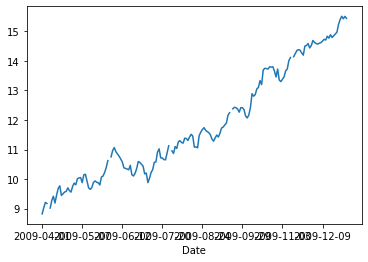

In [5]:
# Plot the Close Data
data['Close'].plot()

# 3. Data Cleaning
Next, we need to clean our data for training our model. This requires removal of NaN values.

In [6]:
# Check for null values
print('Number of Null Values =', data.isnull().sum())

Number of Null Values = Open         5
High         5
Low          5
Close        5
Adj Close    5
Volume       5
dtype: int64


In [7]:
# forward fill missing values
data = data.ffill()
display_df(data)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2009-04-01,8.562406,8.847836,8.483452,8.819193,8.819193,132542948.0
2009-04-02,9.048833,9.209481,8.974362,9.028658,9.028658,180192885.0
2009-04-03,9.078472,9.258298,8.916578,9.209979,9.209979,152160204.0
2009-04-06,9.140738,9.210975,9.001261,9.171623,9.171623,131703815.0
2009-04-07,9.140738,9.210975,9.001261,9.171623,9.171623,131703815.0
2009-04-08,9.053565,9.090925,8.871996,9.016205,9.016205,111022586.0
2009-04-09,9.203005,9.323802,9.122058,9.277725,9.277725,135811153.0
2009-04-13,9.248584,9.442109,9.222930,9.417451,9.417451,122461301.0
2009-04-14,9.388310,9.389556,9.105869,9.188310,9.188310,137658049.0


In [8]:
# Check for null values
print('Number of Null Values =', data.isnull().sum())

Number of Null Values = Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


<Axes: xlabel='Date'>

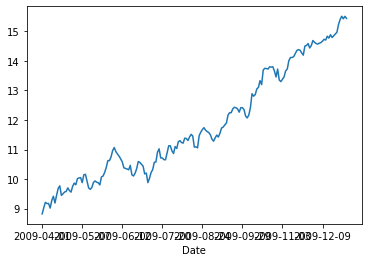

In [9]:
# Plot the cleaned Close Data
data['Close'].plot()

# 4. Feature Selection
Now that we have cleaned our stock data, we need to select which features to train our model on. For this project, we will be training with Close data and 20-day Bollinger Bands of Close.

In [10]:
# Calculate 20-day bollinger bands
data['MA20'] = data['Close'].rolling(window=20).mean()
data['STD20'] = data['Close'].rolling(window=20).std()
data['BB_upper'] = data['MA20'] + (data['STD20'] * 2)
data['BB_lower'] = data['MA20'] - (data['STD20'] * 2)
display_df(data)

,Open,High,Low,Close,Adj Close,Volume,MA20,STD20,BB_upper,BB_lower
Date,,,,,,,,,,
2009-04-01,8.562406,8.847836,8.483452,8.819193,8.819193,132542948.0,NaN,NaN,NaN,NaN
2009-04-02,9.048833,9.209481,8.974362,9.028658,9.028658,180192885.0,NaN,NaN,NaN,NaN
2009-04-03,9.078472,9.258298,8.916578,9.209979,9.209979,152160204.0,NaN,NaN,NaN,NaN
2009-04-06,9.140738,9.210975,9.001261,9.171623,9.171623,131703815.0,NaN,NaN,NaN,NaN
2009-04-07,9.140738,9.210975,9.001261,9.171623,9.171623,131703815.0,NaN,NaN,NaN,NaN
2009-04-08,9.053565,9.090925,8.871996,9.016205,9.016205,111022586.0,NaN,NaN,NaN,NaN
2009-04-09,9.203005,9.323802,9.122058,9.277725,9.277725,135811153.0,NaN,NaN,NaN,NaN
2009-04-13,9.248584,9.442109,9.222930,9.417451,9.417451,122461301.0,NaN,NaN,NaN,NaN
2009-04-14,9.388310,9.389556,9.105869,9.188310,9.188310,137658049.0,NaN,NaN,NaN,NaN


In [11]:
# Remove rows with NaN bollinger bands
data = data.dropna(axis=0)
display_df(data)

,Open,High,Low,Close,Adj Close,Volume,MA20,STD20,BB_upper,BB_lower
Date,,,,,,,,,,
2009-04-29,9.613217,9.837377,9.609730,9.750204,9.750204,144941247.0,9.395770,0.271027,9.937823,8.853717
2009-04-30,9.857053,10.056057,9.833143,9.862284,9.862284,174881049.0,9.447924,0.254066,9.956057,8.939792
2009-05-01,9.838871,9.902633,9.752196,9.805497,9.805497,97471985.0,9.486766,0.245844,9.978454,8.995079
2009-05-04,9.917078,10.022433,9.832894,10.011973,10.011973,128600225.0,9.526866,0.263121,10.053107,9.000625
2009-05-05,9.962159,10.087191,9.894164,10.037128,10.037128,96391952.0,9.570141,0.272622,10.115385,9.024898
2009-05-06,10.131774,10.168885,9.987564,10.049084,10.049084,105710750.0,9.614014,0.275700,10.165415,9.062614
2009-05-07,10.064775,10.086942,9.775858,9.878224,9.878224,120441759.0,9.657115,0.242734,10.142584,9.171646
2009-05-08,10.033641,10.214962,9.838124,10.145223,10.145223,155183494.0,9.700490,0.248804,10.198098,9.202882
2009-05-11,10.032396,10.261537,9.992545,10.161413,10.161413,102755715.0,9.737688,0.259638,10.256965,9.218412


In [12]:
# Define new dataframe with only the training features (Close, Upper BB, Lower BB)
dataset = data[['Close', 'BB_upper', 'BB_lower']]
display_df(dataset)

,Close,BB_upper,BB_lower
Date,,,
2009-04-29,9.750204,9.937823,8.853717
2009-04-30,9.862284,9.956057,8.939792
2009-05-01,9.805497,9.978454,8.995079
2009-05-04,10.011973,10.053107,9.000625
2009-05-05,10.037128,10.115385,9.024898
2009-05-06,10.049084,10.165415,9.062614
2009-05-07,9.878224,10.142584,9.171646
2009-05-08,10.145223,10.198098,9.202882
2009-05-11,10.161413,10.256965,9.218412


# 5. Normalization
Now that we have cleaned our data, created our indicators of interest, and selected our features, we must normalize our data. For this project, we use the sklearn StandardScaler, which centers the data and normalizes to unit variance. We will not be using a rolling scaler for this project, due to the complexity of back-translating to true proce and indicator values - you can try this yourself once you have completed the project. 

,Close,BB_upper,BB_lower
Date,,,
2009-04-29,9.750204,9.937823,8.853717
2009-04-30,9.862284,9.956057,8.939792
2009-05-01,9.805497,9.978454,8.995079
2009-05-04,10.011973,10.053107,9.000625
2009-05-05,10.037128,10.115385,9.024898
2009-05-06,10.049084,10.165415,9.062614
2009-05-07,9.878224,10.142584,9.171646
2009-05-08,10.145223,10.198098,9.202882
2009-05-11,10.161413,10.256965,9.218412


<Axes: xlabel='Date'>

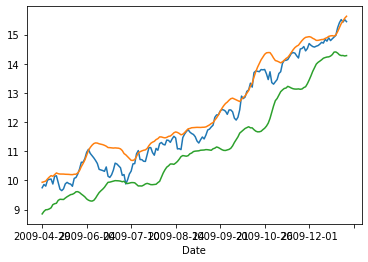

In [13]:
# Display & Plot Un-normalized Dataset
display_df(dataset)
dataset['Close'].plot()
dataset['BB_upper'].plot()
dataset['BB_lower'].plot()

In [14]:
# Normalize Dataset with StandardScaler
normlist = []
normed_dataset = pd.DataFrame(index=dataset.index)
for col in dataset.columns:
    normalizer = StandardScaler()
    column_data = pd.DataFrame(dataset[col])
    normalizer.fit(column_data)
    normed_dataset[col] = normalizer.transform(column_data).flatten()
    normlist.append(normalizer)

,Close,BB_upper,BB_lower
Date,,,
2009-04-29,-1.341805,-1.450150,-1.430416
2009-04-30,-1.277192,-1.439244,-1.377255
2009-05-01,-1.309929,-1.425848,-1.343109
2009-05-04,-1.190897,-1.381197,-1.339683
2009-05-05,-1.176395,-1.343949,-1.324692
2009-05-06,-1.169503,-1.314025,-1.301398
2009-05-07,-1.268002,-1.327681,-1.234058
2009-05-08,-1.114080,-1.294477,-1.214766
2009-05-11,-1.104746,-1.259269,-1.205175


<Axes: xlabel='Date'>

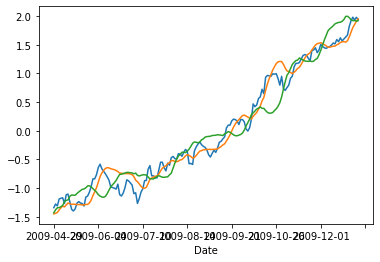

In [15]:
# Display & Plot Normalized Dataset
display_df(normed_dataset)
normed_dataset['Close'].plot()
normed_dataset['BB_upper'].plot()
normed_dataset['BB_lower'].plot()

# 6. Train / Test Split
Now that our data cleaned, features are selected, and the dataset is normalized, we are ready to feed the data into our model. With this in mind, we split the data ito train and test data (50/50 split)

In [16]:
# split dataset df into train (50%) and test (50%) datasets
training_rows = int(len(normed_dataset.index)*0.5)
train_df = normed_dataset.iloc[:training_rows]
test_df = normed_dataset.iloc[training_rows:]

In [17]:
# display train and test dfs (ensure no overlap)
display_df(train_df)
display_df(test_df)

,Close,BB_upper,BB_lower
Date,,,
2009-04-29,-1.341805,-1.450150,-1.430416
2009-04-30,-1.277192,-1.439244,-1.377255
2009-05-01,-1.309929,-1.425848,-1.343109
2009-05-04,-1.190897,-1.381197,-1.339683
2009-05-05,-1.176395,-1.343949,-1.324692
2009-05-06,-1.169503,-1.314025,-1.301398
2009-05-07,-1.268002,-1.327681,-1.234058
2009-05-08,-1.114080,-1.294477,-1.214766
2009-05-11,-1.104746,-1.259269,-1.205175


,Close,BB_upper,BB_lower
Date,,,
2009-08-31,-0.333839,-0.324508,-0.101821
2009-09-01,-0.418697,-0.324366,-0.098844
2009-09-02,-0.458183,-0.325247,-0.095058
2009-09-03,-0.393426,-0.326468,-0.082783
2009-09-04,-0.339151,-0.323058,-0.079844
2009-09-08,-0.377632,-0.322125,-0.077715
2009-09-09,-0.300814,-0.315388,-0.069243
2009-09-10,-0.200735,-0.294361,-0.071943
2009-09-11,-0.183505,-0.274560,-0.077222


In [18]:
# convert train and test dfs to np arrays with dtype=float
X_train = train_df.values.astype(float)
X_test = test_df.values.astype(float)
# print the shape of X_train to remind yourself how many examples and features are in the dataset
print(X_train.shape)
# track index to remember which feature is which
idx_close = 0  # numerical idx of close data column in array
idx_bb_upper = 1  # numerical idx of BB Upper data column in array
idx_bb_lower = 2  # numerical idx of BB Lower data column in array

(86, 3)


# 7. Define the Agent
Now that our data is ready to use, we can define the Reinforcement Learning Agent.

### Define the DQN Model
The first step in defining our agent is the Deep Q-Network model definition. For this project, we are creating a model sequential model with four layers. The first three layers have output shape of 64, 32, and 8, respectively, and a RELU activation. The output layer has an output shape of the size of our action space (buy, sell, hold), and a linear activation. Our Loss finction is Mean Squared Error, and our optimizer is Adam with a learning rate of 0.001. Use Keras to build this model.

In [19]:
# Define DQN Model Architecture
class DQN(keras.Model):
    def __init__(self, state_size, action_size):
        super().__init__()
        # define model layers in keras
        model = keras.models.Sequential()
        # Input Layer + First Hidden Layer
        model.add(keras.layers.Dense(units=64, input_dim=state_size, activation="relu"))
        # Second Hidden Layer
        model.add(keras.layers.Dense(units=32, activation="relu"))
        # Third Hidden Layer
        model.add(keras.layers.Dense(units=8, activation="relu"))
        # Output Layer
        model.add(keras.layers.Dense(action_size, activation="linear"))
        
        # compile model in keras
        model.compile(loss="mse", optimizer=keras.optimizers.Adam(learning_rate=0.001))
        
        # save model to DQN instance
        self.model = model

### Define Agent Class
Now that we have defined our underlying DQN Model, we must define out Reinforcement Learning Agent. The agent initialization is provided for you, you must define an act function, and an expereince replay function. As a reminder, the act function defines how our model will act (buy, hold, or sell) given a certain state. The Experience Replay function tackles catastrophic forgetting in our training process, by maintaining a memory buffer to allow training on independent / randomized minibatches of previous states. 

In [20]:
class Agent:
    def __init__(self, window_size, num_features, test_mode=False, model_name=''):
        self.window_size = window_size # How many days of historical data do we want to include in our state representation?
        self.num_features = num_features # How many training features do we have?
        self.state_size = window_size*num_features # State size includes number of training features per day, and number of lookback days 
        self.action_size = 3 # 0=hold, 1=buy, 2=sell
        self.memory = deque(maxlen=1000) # Bound memory size: once the memory reaches 1000 units, the lefthand values are discarded as righthand values are added
        self.inventory = [] # Inventory to hold trades
        self.model_name = model_name # filename for saved model checkpoint loading
        self.test_mode = test_mode # flag for testing (allows model load from checkpoint model_name)

        self.gamma = 0.95
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.99  # CHANGED from 0.995 to 0.99 for slower decay = more exploration
        
        self.model = keras.models.load_model(model_name) if test_mode else self._model()

    #Deep Q Learning (DQL) model
    def _model(self):
        model = DQN(self.state_size, self.action_size).model
        return model
    
    # DQL Predict (with input reshaping)
    #   Input = State
    #   Output = Q-Table of action Q-Values
    def get_q_values_for_state(self, state):
        return self.model.predict(state.flatten().reshape(1, self.state_size), verbose=0)  # Added verbose=0 to reduce output
    

    # DQL Fit (with input reshaping)
    #   Input = State, Target Q-Table 
    #   Output = MSE Loss between Target Q-Table and Actual Q-Table for State
    def fit_model(self, input_state, target_output):
        return self.model.fit(input_state.flatten().reshape(1, self.state_size), target_output, epochs=1, verbose=0)    
    
    # Agent Action Selector with Action Masking
    #   Input = State, inventory_size
    #   Policy = epsilon-greedy (to minimize possibility of overfitting)
    #   Action Masking = Prevents invalid actions (e.g., selling with no inventory)
    #   Initially high epsilon = more random, epsilon decay = less random later
    #   Output = Action (0, 1, or 2)
    def act(self, state, inventory_size=0): 
        # Define valid actions based on current inventory
        # HOLD (0) and BUY (1) are always valid
        # SELL (2) is only valid if we have inventory
        valid_actions = [0, 1]  # HOLD and BUY
        if inventory_size > 0:
            valid_actions.append(2)  # Add SELL if we have inventory
        
        # Epsilon-greedy: Choose random action from valid actions
        if not self.test_mode and random.random() <= self.epsilon:
            return random.choice(valid_actions)
        
        # Get Q-values for all actions
        options = self.get_q_values_for_state(state)[0].copy()
        
        # Mask invalid actions by setting their Q-value to negative infinity
        if inventory_size == 0:
            options[2] = -np.inf  # Mask SELL action when no inventory
        
        # Choose action with highest Q-value among valid actions
        return np.argmax(options)
 
    # Experience Replay (Learning Function)
    #   Input = Batch of (state, action, next_state) tuples
    #   Optimal Q Selection Policy = Bellman equation
    #   Important Notes = Model fitting step is in this function (fit_model)
    #                     Epsilon decay step is in this function
    #   Output = Model loss from fitting step
    def exp_replay(self, batch_size):
        losses = []
        # define a mini-batch which holds batch_size most recent previous memory steps (i.e. states)
        mini_batch = []
        l = len(self.memory)
        for i in range(l - batch_size + 1, l):
            mini_batch.append(self.memory[i])
            
        for state, action, reward, next_state, done in mini_batch:
            # reminders: 
            #   - state is a vector containing close & MA values for the current time step
            #   - action is an integer representing the action taken by the act function at the current time step- buy, hold, or sell
            #   - reward represents the profit of a given action - it is either 0 (for buy, hold, and sells which loose money) or the profit in dollars (for a profitable sell)
            #   - next_state is a vector containing close & MA values for the next time step
            #   - done is a boolean flag representing whether or not we are in the last iteration of a training episode (i.e. True when next_state does not exist.)
            if done:
                # special condition for last training epoch in batch (no next_state)
                optimal_q_for_action = reward  
            else:
                # target Q-value is updated using the Bellman equation: reward + gamma * max(predicted Q-value of next state)
                optimal_q_for_action = reward + self.gamma * np.max(self.get_q_values_for_state(next_state))
            # Get the predicted Q-values of the current state
            target_q_table = self.get_q_values_for_state(state)
            # Update the output Q table - replace the predicted Q value for action with the target Q value for action 
            target_q_table[0][action] = optimal_q_for_action
            # Fit the model where state is X and target_q_table is Y
            history = self.fit_model(state, target_q_table)
            losses += history.history['loss']
           
        # define epsilon decay (for the act function)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
        return losses

# 8. Train the Agent
Now that our data is ready and our agent is defined, we are ready to train the agent. 

### Helper Functions
Before we define the training loop, we will write some helper functions: one for printing price data, one to define the sigmoid funtion, one to grab the state representation,  one to plot the trading output of our trained model, and one to plot the training loss. The printing, sigmoid, and plotting functions are defined for you. You must define the function which gets the state representation.

In [21]:
# Format price string
def format_price(n):
    return ('-$' if n < 0 else '$') + '{0:.2f}'.format(abs(n))

def sigmoid(x):
    return 1 / (1 + math.exp(-x))

# Plot behavior of trade output
def plot_behavior(data_input, bb_upper_data, bb_lower_data, states_buy, states_sell, profit, train=True):
    fig = plt.figure(figsize = (15,5))
    plt.plot(data_input, color='k', lw=2., label= 'Close Price')
    plt.plot(bb_upper_data, color='b', lw=2., label = 'Bollinger Bands')
    plt.plot(bb_lower_data, color='b', lw=2.)
    plt.plot(data_input, '^', markersize=10, color='r', label = 'Buying signal', markevery = states_buy)
    plt.plot(data_input, 'v', markersize=10, color='g', label = 'Selling signal', markevery = states_sell)
    plt.title('Total gains: %f'%(profit))
    plt.legend()
    if train:
        plt.xticks(range(0, len(train_df.index.values), int(len(train_df.index.values)/15)), train_df.index.values[0:: int(len(train_df.index.values)/15)], rotation=45, fontsize='small')
    else:
        plt.xticks(range(0, len(test_df.index.values), int(len(test_df.index.values)/15)), test_df.index.values[0::int(len(test_df.index.values)/15)], rotation=45, fontsize='small')
    plt.show()

# Plot training loss
def plot_losses(losses, title):
    plt.plot(losses)
    plt.title(title)
    plt.ylabel('MSE Loss Value')
    plt.xlabel('batch')
    plt.show()

# returns an an n-day state representation ending at time t
def get_state(data, t, n): 
    # data is the dataset of interest which holds the state values (i.e. Close , BB Upper, BB Lower)
    # t is the current time step 
    # n is the size of the training window 

    # the first step is to get the window of the dataset at the current time step (eg. if window size is 1, we grab the previous and the current time step)
    # remember to define the special case for the first iteration, where there is no previous time step.
    d = t - n + 1
    block = data[d:t + 1] if d >= 0 else -d * [data[0]] + list(data[0:t + 1])
    
    # once we have our state data, we need to apply the sigmoid to each feature.
    res = []
    for i in range(n - 1):
        for j in range(len(block[0])):
            res.append(sigmoid(block[i + 1][j] - block[i][j]))
    # return an array holding the n-day sigmoid state representation
    return np.array([res])

### Training Loop

In [22]:
# display the shape of your training data in order to remond yourself how may features and examples there are in your training set
print(X_train.shape)

(86, 3)


In [23]:
# keras.utils.disable_interactive_logging()  # disable built-in keras loading bars - they make the output difficult to read and monitor (not available in Keras 2.12)

window_size = 1

agent = Agent(window_size, num_features=X_train.shape[1])

In [24]:
l = len(X_train) - 1

# batch size defines how often to run the exp_replay method
batch_size = 32

#An episode represents a complete pass over the data.
episode_count = 2

# Guardrail parameters
MAX_SHARES = 1  # Number of shares to buy/sell per transaction (currently always buys/sells this amount)
STOP_LOSS_PCT = 0.30  # 30% stop loss
TAKE_PROFIT_PCT = 0.20  # 20% take profit
HOLDING_PENALTY = 0.05  # Penalty when holding cash (no position) to encourage buying

normalizer_close = normlist[0]  # get the close normalizer from normlist
normalizer_bb_upper = normlist[1]  # get the BB upper normalizer from normlist
normalizer_bb_lower = normlist[2]  # get the BB lower normalizer from normlist

Buy: 1 shares at $10.15 (Total: $10.15)
Sell: 1 shares at $10.16 (Total: $10.16) | Profit: $0.02
Buy: 1 shares at $9.65 (Total: $9.65)
Already have a position - converting BUY to HOLD
Already have a position - converting BUY to HOLD
Already have a position - converting BUY to HOLD
Sell: 1 shares at $9.80 (Total: $9.80) | Profit: $0.15
Buy: 1 shares at $10.07 (Total: $10.07)
Already have a position - converting BUY to HOLD
Sell: 1 shares at $10.22 (Total: $10.22) | Profit: $0.15
Buy: 1 shares at $10.39 (Total: $10.39)
Sell: 1 shares at $10.62 (Total: $10.62) | Profit: $0.23
Buy: 1 shares at $11.07 (Total: $11.07)
Already have a position - converting BUY to HOLD
Already have a position - converting BUY to HOLD
Already have a position - converting BUY to HOLD
Sell: 1 shares at $10.68 (Total: $10.68) | Profit: -$0.38
Buy: 1 shares at $10.36 (Total: $10.36)
Sell: 1 shares at $10.34 (Total: $10.34) | Profit: -$0.02
Buy: 1 shares at $10.10 (Total: $10.10)
Sell: 1 shares at $10.36 (Total: $10.

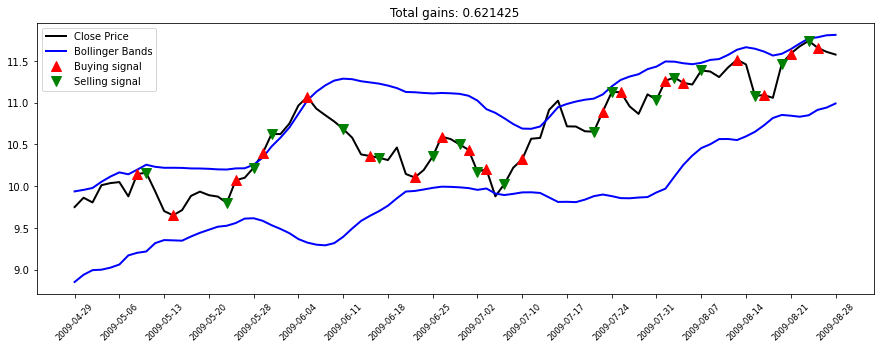

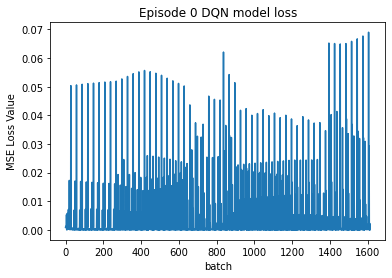


Model saved: model_ep0.keras


Buy: 1 shares at $9.75 (Total: $9.75)
Sell: 1 shares at $9.86 (Total: $9.86) | Profit: $0.11
Buy: 1 shares at $9.81 (Total: $9.81)
Sell: 1 shares at $10.01 (Total: $10.01) | Profit: $0.21
Buy: 1 shares at $10.04 (Total: $10.04)
Sell: 1 shares at $10.05 (Total: $10.05) | Profit: $0.01
Buy: 1 shares at $9.88 (Total: $9.88)
Sell: 1 shares at $10.15 (Total: $10.15) | Profit: $0.27
Buy: 1 shares at $10.16 (Total: $10.16)
Sell: 1 shares at $9.94 (Total: $9.94) | Profit: -$0.22
Buy: 1 shares at $9.65 (Total: $9.65)
Sell: 1 shares at $9.71 (Total: $9.71) | Profit: $0.06
Buy: 1 shares at $9.88 (Total: $9.88)
Already have a position - converting BUY to HOLD
Sell: 1 shares at $10.22 (Total: $10.22) | Profit: $0.35
Buy: 1 shares at $10.39 (Total: $10.39)
Sell: 1 shares at $10.62 (Total: $10.62) | Profit: $0.23
Buy: 1 shares at $10.62 (Total: $10.62)
Sell: 1 shares at $10.75 (Total: $10.75) | Profit: $0.13
Buy: 1 shares at $11.07 (Total: $11.07)
Already have a position - converting BUY to HOLD
Sell

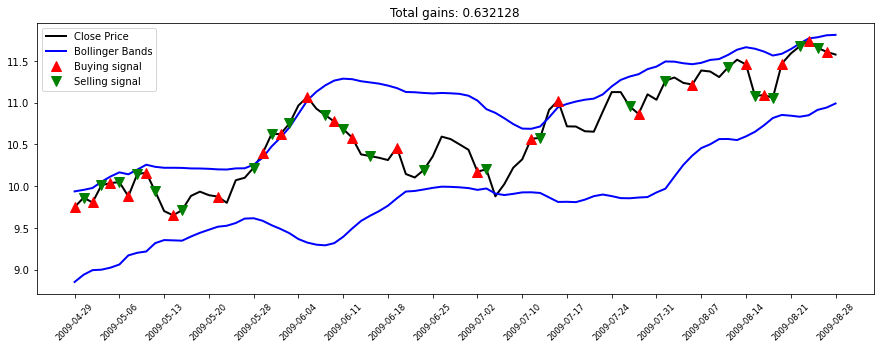

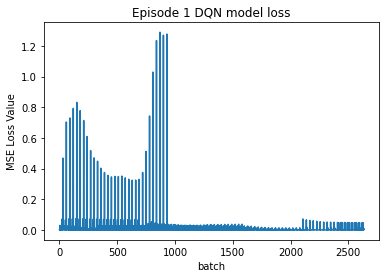


Model saved: model_ep1.keras


In [25]:
# keras.config.disable_traceback_filtering() # disable built-in keras loading bars - they make the output difficult to read and monitor (not available in Keras 2.12)


X_train_true_price = normalizer_close.inverse_transform(X_train[:, idx_close].reshape(-1, 1)).flatten()
X_train_true_bb_upper = normalizer_bb_upper.inverse_transform(X_train[:, idx_bb_upper].reshape(-1, 1)).flatten()
X_train_true_bb_lower = normalizer_bb_lower.inverse_transform(X_train[:, idx_bb_lower].reshape(-1, 1)).flatten()

batch_losses = []
num_batches_trained = 0

for e in range(episode_count):
    state = get_state(X_train, 0, window_size + 1)
    # initialize variables
    total_profit = 0
    total_winners = 0
    total_losers = 0
    # Inventory now stores: None (no position) or (buy_price, num_shares)
    position = None
    states_sell = []
    states_buy = []
    for t in tqdm(range(l), desc=f'Running episode {e + 1}/{episode_count}'):
        # get the action with action masking (pass whether we have a position)
        has_position = position is not None
        action = agent.act(state, 1 if has_position else 0)
        # get the next state
        next_state = get_state(X_train, t + 1, window_size + 1)
        
        # Get current price for guardrail checks
        current_price = normalizer_close.inverse_transform(X_train[t, idx_close].reshape(-1, 1))[0][0]
        
        # Track if we sell today (to prevent buying on same day)
        sold_today = False
        
        # GUARDRAIL 1: Check stop loss and take profit on existing position
        guardrail_reward = 0
        if position is not None:
            buy_price, num_shares = position
            pnl_pct = (current_price - buy_price) / buy_price
            if pnl_pct <= -STOP_LOSS_PCT:  # Stop loss triggered
                trade_profit = (current_price - buy_price) * num_shares
                guardrail_reward = trade_profit
                total_profit += trade_profit
                if trade_profit >= 0:
                    total_winners += trade_profit
                else:
                    total_losers += trade_profit
                states_sell.append(t)
                sold_today = True
                position = None  # Clear position
                print(f'STOP LOSS triggered: Sold {num_shares} shares at {format_price(current_price)} (bought at {format_price(buy_price)}) | Profit: {format_price(trade_profit)}')
            elif pnl_pct >= TAKE_PROFIT_PCT:  # Take profit triggered
                trade_profit = (current_price - buy_price) * num_shares
                guardrail_reward = trade_profit
                total_profit += trade_profit
                if trade_profit >= 0:
                    total_winners += trade_profit
                else:
                    total_losers += trade_profit
                states_sell.append(t)
                sold_today = True
                position = None  # Clear position
                print(f'TAKE PROFIT triggered: Sold {num_shares} shares at {format_price(current_price)} (bought at {format_price(buy_price)}) | Profit: {format_price(trade_profit)}')
        
        # GUARDRAIL 2: Prevent buy if already have a position
        if action == 1 and position is not None:
            print(f'Already have a position - converting BUY to HOLD')
            action = 0  # Force hold
        
        # GUARDRAIL 3: Prevent buy on same day as sell
        if action == 1 and sold_today:
            print(f'Already sold today - preventing BUY, converting to HOLD')
            action = 0  # Force hold
        
        # initialize reward for the current time step
        reward = guardrail_reward  # Start with any guardrail rewards

        if action == 1: # buy MAX_SHARES shares
            buy_price = current_price
            num_shares = MAX_SHARES
            position = (buy_price, num_shares)
            states_buy.append(t)
            print(f'Buy: {num_shares} shares at {format_price(buy_price)} (Total: {format_price(buy_price * num_shares)})')

        elif action == 2: # sell ALL shares (action masking ensures we have a position)
            buy_price, num_shares = position
            sell_price = current_price
            # Calculate profit for all shares
            trade_profit = (sell_price - buy_price) * num_shares
            reward += trade_profit
            total_profit += trade_profit
            if trade_profit >= 0:
                total_winners += trade_profit
            else:
                total_losers += trade_profit
            states_sell.append(t)
            sold_today = True
            position = None  # Clear position
            print(f'Sell: {num_shares} shares at {format_price(sell_price)} (Total: {format_price(sell_price * num_shares)}) | Profit: {format_price(trade_profit)}')
        
        elif action == 0:  # hold
            # Apply holding penalty when NOT holding a position (encourages buying)
            if position is None:
                reward -= HOLDING_PENALTY

        # flag for final training iteration
        done = True if t == l - 1 else False

        # append the details of the state action etc in the memory, to be used by the exp_replay function
        agent.memory.append((state, action, reward, next_state, done))
        state = next_state

        # print total profit and plot behaviour of the current episode when the episode is finished
        if done:
            print('--------------------------------')
            print(f'Episode {e}')
            print(f'Total Profit: {format_price(total_profit)}')
            print(f'Total Winners: {format_price(total_winners)}')
            print(f'Total Losers: {format_price(total_losers)}')
            if len(batch_losses) > num_batches_trained:
                print(f'Max Loss: {max(batch_losses[num_batches_trained:len(batch_losses)])}')
                print(f'Total Loss: {sum(batch_losses[num_batches_trained:len(batch_losses)])}')
            print('--------------------------------')
            plot_behavior(X_train_true_price, X_train_true_bb_upper, X_train_true_bb_lower, states_buy, states_sell, total_profit)
            if len(batch_losses) > num_batches_trained:
                plot_losses(batch_losses[num_batches_trained:len(batch_losses)], f'Episode {e} DQN model loss')
            num_batches_trained = len(batch_losses)

        # when the size of the memory is greater than the batch size, run the exp_replay function on the batch to fit the model and get losses for the batch
        # then sum the losses for the batch and append them to the batch_losses list
        if len(agent.memory) > batch_size:
            losses = agent.exp_replay(batch_size)
            batch_losses.extend(losses)
            
    # Save model after every episode
    agent.model.save(f'model_ep{e}.keras')
    print(f'Model saved: model_ep{e}.keras')

### Plot Training Loss

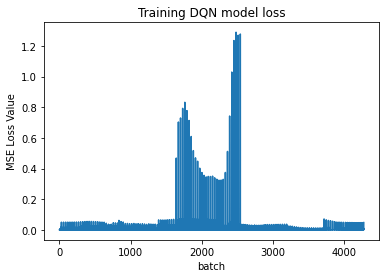

In [26]:
# use the plot_losses function to plot all batch_losses for the entire training round
plot_losses(batch_losses, 'Training DQN model loss')

# 9. Test the trained agent 
Finally, we get to test our trained model to see how well it performs in our test set. Using the training loop above, define a method to run our trained model on our X_test dataset. 

### Define Parameters
Some test parameters are defined for you below. Fill out the missing data. If you need a hint, look up at the training loop. 

In [27]:
# Define guardrail parameters for test phase (same as training)
MAX_SHARES = 1  # Number of shares to buy/sell per transaction (currently always buys/sells this amount)
STOP_LOSS_PCT = 0.30  # 30% stop loss
TAKE_PROFIT_PCT = 0.20  # 20% take profit
HOLDING_PENALTY = 0.05  # Penalty when holding cash (no position) to encourage buying

In [28]:
l_test = len(X_test) - 1
total_profit = 0
total_winners = 0
total_losers = 0
done = False
states_sell_test = []
states_buy_test = []

# Calculate which model to load based on episode_count
# The last episode is always saved, so load the model from the last episode (episode_count - 1)
last_episode = episode_count - 1
model_filename = f'model_ep{last_episode}.keras'

print(f'Loading model from last episode: {model_filename}')
agent = Agent(window_size, num_features=X_test.shape[1], test_mode=True, model_name=model_filename)

state = get_state(X_test, 0, window_size + 1)

X_test_true_price = normalizer_close.inverse_transform(X_test[:, idx_close].reshape(-1, 1)).flatten()
X_test_true_bb_upper = normalizer_bb_upper.inverse_transform(X_test[:, idx_bb_upper].reshape(-1, 1)).flatten()
X_test_true_bb_lower = normalizer_bb_lower.inverse_transform(X_test[:, idx_bb_lower].reshape(-1, 1)).flatten()

Loading model from last episode: model_ep1.keras


### Run the Test
Run the test data through the trained model. Look at the training loop for a hint.

Buy: 1 shares at $11.50 (Total: $11.50)
Sell: 1 shares at $11.35 (Total: $11.35) | Profit: -$0.15
Buy: 1 shares at $11.28 (Total: $11.28)
Sell: 1 shares at $11.40 (Total: $11.40) | Profit: $0.11
Buy: 1 shares at $11.49 (Total: $11.49)
Sell: 1 shares at $11.42 (Total: $11.42) | Profit: -$0.07
Buy: 1 shares at $11.56 (Total: $11.56)
Sell: 1 shares at $11.73 (Total: $11.73) | Profit: $0.17
Buy: 1 shares at $11.76 (Total: $11.76)
Sell: 1 shares at $11.83 (Total: $11.83) | Profit: $0.07
Buy: 1 shares at $11.89 (Total: $11.89)
Sell: 1 shares at $12.16 (Total: $12.16) | Profit: $0.27
Buy: 1 shares at $12.25 (Total: $12.25)
Sell: 1 shares at $12.25 (Total: $12.25) | Profit: $0.00
Buy: 1 shares at $12.38 (Total: $12.38)
Sell: 1 shares at $12.43 (Total: $12.43) | Profit: $0.05
Buy: 1 shares at $12.41 (Total: $12.41)
Sell: 1 shares at $12.37 (Total: $12.37) | Profit: -$0.04
Buy: 1 shares at $12.27 (Total: $12.27)
Sell: 1 shares at $12.42 (Total: $12.42) | Profit: $0.15
Buy: 1 shares at $12.42 (To

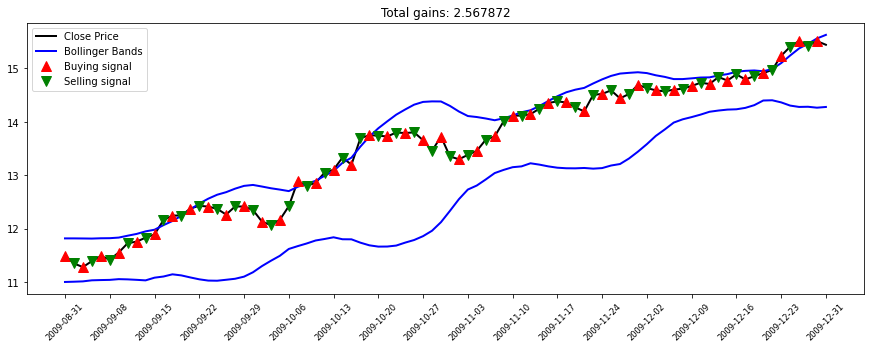

In [29]:
position = None  # Track position: None or (buy_price, num_shares)

for t in range(l_test):
    # get the action with action masking (pass whether we have a position)
    has_position = position is not None
    action = agent.act(state, 1 if has_position else 0)
    next_state = get_state(X_test, t + 1, window_size + 1)
    
    # Get current price for guardrail checks
    current_price = normalizer_close.inverse_transform(X_test[t, idx_close].reshape(-1, 1))[0][0]
    
    # Track if we sell today (to prevent buying on same day)
    sold_today = False
    
    # GUARDRAIL 1: Check stop loss and take profit on existing position
    guardrail_reward = 0
    if position is not None:
        buy_price, num_shares = position
        pnl_pct = (current_price - buy_price) / buy_price
        if pnl_pct <= -STOP_LOSS_PCT:  # Stop loss triggered
            trade_profit = (current_price - buy_price) * num_shares
            guardrail_reward = trade_profit
            total_profit += trade_profit
            if trade_profit >= 0:
                total_winners += trade_profit
            else:
                total_losers += trade_profit
            states_sell_test.append(t)
            sold_today = True
            position = None  # Clear position
            print(f'STOP LOSS triggered: Sold {num_shares} shares at {format_price(current_price)} (bought at {format_price(buy_price)}) | Profit: {format_price(trade_profit)}')
        elif pnl_pct >= TAKE_PROFIT_PCT:  # Take profit triggered
            trade_profit = (current_price - buy_price) * num_shares
            guardrail_reward = trade_profit
            total_profit += trade_profit
            if trade_profit >= 0:
                total_winners += trade_profit
            else:
                total_losers += trade_profit
            states_sell_test.append(t)
            sold_today = True
            position = None  # Clear position
            print(f'TAKE PROFIT triggered: Sold {num_shares} shares at {format_price(current_price)} (bought at {format_price(buy_price)}) | Profit: {format_price(trade_profit)}')
    
    # GUARDRAIL 2: Prevent buy if already have a position
    if action == 1 and position is not None:
        print(f'Already have a position - converting BUY to HOLD')
        action = 0  # Force hold
    
    # GUARDRAIL 3: Prevent buy on same day as sell
    if action == 1 and sold_today:
        print(f'Already sold today - preventing BUY, converting to HOLD')
        action = 0  # Force hold
    
    # initialize reward for the current time step
    reward = guardrail_reward  # Start with any guardrail rewards

    if action == 1: # buy MAX_SHARES shares
        buy_price = current_price
        num_shares = MAX_SHARES
        position = (buy_price, num_shares)
        states_buy_test.append(t)
        print(f'Buy: {num_shares} shares at {format_price(buy_price)} (Total: {format_price(buy_price * num_shares)})')

    elif action == 2: # sell ALL shares (action masking ensures we have a position)
        buy_price, num_shares = position
        sell_price = current_price
        # Calculate profit for all shares
        trade_profit = (sell_price - buy_price) * num_shares
        reward += trade_profit
        total_profit += trade_profit
        if trade_profit >= 0:
            total_winners += trade_profit
        else:
            total_losers += trade_profit
        states_sell_test.append(t)
        sold_today = True
        position = None  # Clear position
        print(f'Sell: {num_shares} shares at {format_price(sell_price)} (Total: {format_price(sell_price * num_shares)}) | Profit: {format_price(trade_profit)}')
    
    elif action == 0:  # hold
        # Apply holding penalty when NOT holding a position (encourages buying)
        if position is None:
            reward -= HOLDING_PENALTY
    
    if t == l_test - 1:
        done = True
    # append to memory so we can re-train on 'live' (test) data later    
    agent.memory.append((state, action, reward, next_state, done))
    state = next_state

    if done:
        print('------------------------------------------')
        print(f'Total Profit: {format_price(total_profit)}')
        print(f'Total Winners: {format_price(total_winners)}')
        print(f'Total Losers: {format_price(total_losers)}')
        print('------------------------------------------')
        
plot_behavior(X_test_true_price, X_test_true_bb_upper, X_test_true_bb_lower, states_buy_test, states_sell_test, total_profit, train=False)